In [1]:
seed_value= 100
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions:
# tf.compat.v1.set_random_seed(seed_value)
# 5. Configure a new global `tensorflow` session
from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
import keras

2021-12-08 06:52:44.685222: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold #--needed for cross validation
from sklearn.preprocessing import StandardScaler
import pandas as pd
#import keras
import scipy as sc
from scipy import signal
import autokeras as ak
#import tensorflow as tf
from tensorflow.keras import layers
from autokeras import StructuredDataRegressor

In [3]:
class GeoData:
    def __init__(self,file):
        self.Scaler = StandardScaler()
        self.df = pd.read_hdf(file)
        #self.df = pd.read_pickle("./SuperStack.pkl")
        print(self.df.columns) 
        X_df= self.df[["SRC_Lat","SRC_Lon","REC_Lat","REC_Lon"]].copy()
        y_df= self.df[["Greens"]].copy()
       
        
        self.X=  X_df.to_numpy()
        self.y= y_df.to_numpy()
        self.y=  self.y[:,0]
        self.y = [ x.tolist() for x in self.y]
        self.y= np.array(self.y)
        self.y= self.y/ np.max(self.y,axis=1).reshape(-1,1)
                         
        
        #self.y.shape = (380)
        print(self.y.shape)
        #print(self.y)
        print(self.X.shape)
        print(self.X[0])
        print(self.y[0])
testFile_h="./Data/Supersets/hdf/HourStack.hdf"
#testFile_s="SuperStack.hdf"
print("Reading in HourStacked Data...")
Geo = GeoData(testFile_h)

ModelSetName = 'HourStack'

Reading in HourStacked Data...
Index(['SRC_ID', 'REC_ID', 'SRC_Lat', 'SRC_Lon', 'REC_Lat', 'REC_Lon',
       'Greens'],
      dtype='object')
(8284, 3001)
(8284, 4)
[  41.467999 -105.722099   41.467602 -104.824799]
[ 0.03820507  0.03856462  0.03912802 ... -0.14665908 -0.17726582
 -0.2081426 ]


In [4]:

print('-Sameness Check-')
print(Geo.y[0,:] - Geo.y[100,:])
print(Geo.X[0,:] - Geo.X[100,:])


-Sameness Check-
[-0.17987841 -0.18031167 -0.18050829 ... -0.40216358 -0.43070668
 -0.45939681]
[ 0.6409   -0.839698  2.093502  1.014   ]


In [5]:
def kFolds(Geo):
    kf = KFold(n_splits=2)
    X= Geo.X.copy()
    y= Geo.y.copy()
    KFold(n_splits=2, random_state=42, shuffle=True)
    count=0
    print("Will use for Cross Validation for training")
    for train_index, test_index in kf.split(X):
        if(count==0):
            #print("Train:", train_index, "Test:", test_index)
            train_x_crossV1, test_x_crossV1 = X[train_index], X[test_index]
            train_y_crossV1, test_y_crossV1 = y[train_index], y[test_index]
            #print(train_x_crossV1)
            count+=1
        else:
            #print("Train:", train_index, "Test:", test_index)
            train_x_crossV2, test_x_crossV2 = X[train_index], X[test_index]
            train_y_crossV2, test_y_crossV2 = y[train_index], y[test_index]
    return test_x_crossV1,test_y_crossV1,test_x_crossV2,test_y_crossV2


X_train_h,y_train_h,X_test_h,y_test_h= kFolds(Geo) #for hoursStack

Will use for Cross Validation for training


## Model For HourStacked Data

In [6]:
# define the search
search = StructuredDataRegressor(max_trials=15, loss='mean_squared_error',directory='./Models/' + ModelSetName)

# perform the search/fitting to data
search.fit(x=X_train_h, y=y_train_h, verbose=0,validation_split=0.2)
search.fit(x=X_test_h, y=y_test_h, verbose=0,validation_split=0.2)

# evaluate the model
mae_h, _ = search.evaluate(X_test_h, y_test_h, verbose=0)
print('Mean Square Error Average: %.3f' % mae_h)

# get the best performing model
model_h = search.export_model()
# model_h.save('HourStackModel.h5',save_format='tf')
# summarize the loaded model
model_h.summary()
# save the best performing model to file

model_h.compile()

# model.save('model_insurance.h5',save_format='tf')

2021-12-08 06:52:48.611180: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


INFO:tensorflow:Oracle triggered exit
Epoch 1/3
130/130 [==============================] - 1s 3ms/step - loss: 0.1592 - mean_squared_error: 0.1592
Epoch 2/3
130/130 [==============================] - 0s 3ms/step - loss: 0.1587 - mean_squared_error: 0.1587
Epoch 3/3
130/130 [==============================] - 0s 3ms/step - loss: 0.1582 - mean_squared_error: 0.1582


2021-12-08 06:56:51.025516: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./structured_data_regressor/best_model/assets
Mean Square Error Average: 0.156
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 4)                 0         
_________________________________________________________________
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_____________

In [7]:

model_h.predict(Geo.X[10:10+1]) - model_h.predict(Geo.X[50:50+1])


array([[-0.00598792, -0.00446582, -0.00385201, ...,  0.00289475,
        -0.01582707, -0.00379207]], dtype=float32)

In [8]:
from sklearn.metrics import mean_squared_error as MSE

def SSR(y_predict, y_truth):
    assert y_predict.shape[0]==  y_truth.shape[0], "In SSR: give invalid length compared to the length of true outputs"
    result=0
    yDiff = [(y_truth[i] - y_predict[i])**2 for i in range(len(y_truth))] 
    result = np.sum(yDiff)
    return result 

def singleCompare(model_singleCompare,indexNum,X,y, filterVal= False,plot_on = True): #assumed model is trained
    output = model_singleCompare.predict(X[indexNum:indexNum+1]).flatten()
    yTruth = y[indexNum:indexNum+1].flatten()
    
    
    
    low= 5
    high=40
    fs=50
    
    if filterVal:
        output= filterHighFrequency(low,high,fs,output)
        yTruth = filterHighFrequency(low,high,fs,yTruth)

    
    if plot_on:
        t= np.arange(0,3001)
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9,10))
        ax1.set_title("Predicted")
        ax2.set_title("yTrue")
        ax1.plot(t*1/50, output, alpha=.8,color="blue")
        ax2.plot(t*1/50, yTruth,alpha=.8,color="red",linestyle='dashed')
        plt.show()

 

    ssr= SSR(output,yTruth)
    mse= MSE(yTruth,output) 
    if plot_on: 
        print("SSR for Single Sample: ", ssr)
        print("MSE for Single Sample: ", mse)
    return mse

def filterHighFrequency(lowStop,highStop, fs, sig):
    sig = signal.detrend(sig)
    sig = sig - np.mean(sig)
    nyq = 0.5*fs
    wn = [lowStop/nyq,highStop/nyq]
    order = 8
    sos = signal.butter(order,wn,btype="bandpass",fs=fs, output= "sos")
    filteredOutput= signal.detrend(signal.sosfiltfilt(sos,sig))
    filteredOutput = filteredOutput - np.mean(filteredOutput)
    return filteredOutput

def singlePredict(indexNum):
    # use the model to make a prediction
    N = indexNum
    X_new = X_test[0:(N),:]
    X_new = np.asarray(X_new).astype('float32')
    yhat = search.predict(X_new)
    # print('Predicted: %.3f' % yhat[0])
low= 5
high=40
fs=50    
def quickFilter(lowStop,highStop, fs, sig):
    sig = signal.detrend(sig)
    sig = sig - np.mean(sig)
    nyq = 0.5*fs
    wn = [lowStop/nyq,highStop/nyq]
    order = 8
    sos = signal.butter(order,wn,btype="bandpass",fs=fs, output= "sos")
    filteredOutput= signal.detrend(signal.sosfiltfilt(sos,sig),axis=1)
    filteredOutput = filteredOutput - np.mean(filteredOutput,axis=1).reshape((-1,1)) 
    return filteredOutput


In [9]:
#singleCompare(model_s,0,Geo_s.X,Geo_s.y,True)
a1 = model_h.predict(Geo.X[0:1])
a2 = model_h.predict(Geo.X[25:26])
a2-a1

array([[ 3.1894497e-03,  8.4373169e-05, -3.5758996e-03, ...,
         2.5747310e-02,  2.1578252e-02,  7.5028688e-03]], dtype=float32)

In [10]:
Geo.X.shape

(8284, 4)

In [11]:
flt = True

mse_h = []
mse_g = []

#mse_h
yhat_h = model_h.predict(Geo.X)
mse_h= [MSE(yhat_h[i],Geo.y[i]) for i in range(len(yhat_h))]
print("output_h shape: ",yhat_h.shape)
print("mse_h shape: ",len(mse_h))  
print("Average MSE HS Data: ", np.mean(mse_h))

output_h shape:  (8284, 3001)
mse_h shape:  8284
Average MSE HS Data:  0.1557142436603197


In [12]:
flt = True
mse_s = []

output = model_h.predict(Geo.X)

#yTruth = Geo.y/np.max(Geo.y,axis=1).reshape((-1,1))
#output = output/np.max(output,axis=1).reshape((-1,1)) #---------------------------------norming here
output= quickFilter(low,high,fs,output)
yTruth = quickFilter(low,high,fs,Geo.y)
#yTruth = yTruth/np.max(yTruth,axis=1).reshape((-1,1)) 
#output = output/np.max(output,axis=1).reshape((-1,1)) #---------------------------------norming here


mse_s= [MSE(output[i],yTruth[i]) for i in range(len(output))]
print("output_s shape: ",output.shape)
print("mse_s shape: ",len(mse_s))  
print("avg mse", np.mean(mse_s))

output_s shape:  (8284, 3001)
mse_s shape:  8284
avg mse 0.04442730728038105


Average MSE HS Data:  0.1557142436603197


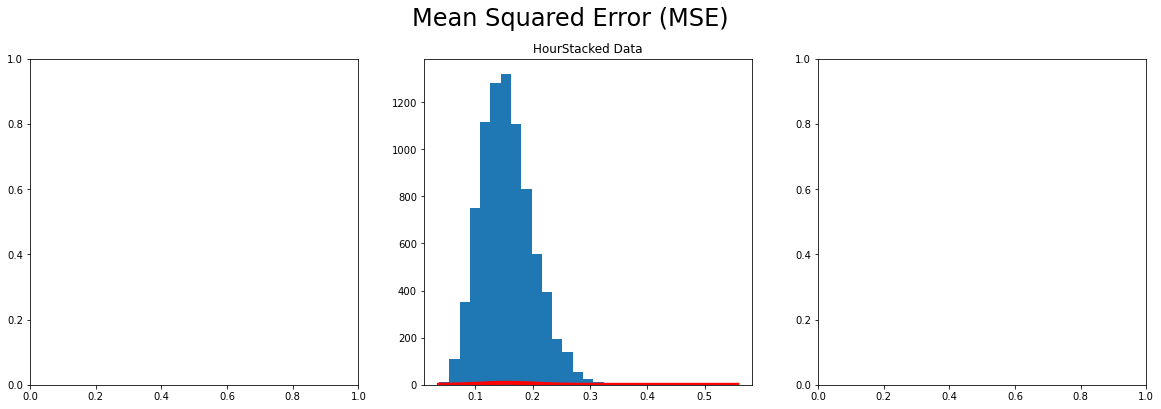

In [13]:
def histogramCompare(mse_Super,mse_Hour,mse_Giant):
    fig, (ax1, ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
    
    plt.suptitle("Mean Squared Error (MSE)",y=1,ha="center",size=24)
    
    
    #Hour Stacked Data
    mu_h, std_h = sc.stats.norm.fit(mse_Hour)
    xVect_h= np.linspace(np.min(mse_Hour),np.max(mse_Hour),30)
    ax2.set_title('HourStacked Data')
    ax2.hist(mse_Hour,bins= xVect_h)
    p_h= sc.stats.norm.pdf(xVect_h,mu_h,std_h)
    ax2.plot(xVect_h,p_h,color="red", linewidth=4)
    print("Average MSE HS Data: ", np.mean(mse_Hour))
    
histogramCompare(0,mse_h,0)

In [14]:
#plt.plot(np.arange(0,len(mse)),mse)
#plt.plot(np.arange(0,len(mse)),np.arange(0,len(mse))*0 + np.mean(mse),color="red")